<a href="https://colab.research.google.com/github/pdkary/VincentGANVogh/blob/main/VincentGANVogh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vincent GAN Vogh
a simple GAN for creating works on art, totally ripping off Van Gogh's style, without any of the artistic expertise

## Imports


In [26]:
%tensorflow_version 2.x
!pip install jupyterplot

import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D, Input, Conv2DTranspose
from keras.layers import InputLayer, Dense, Reshape, Flatten, BatchNormalization
from keras.layers import AveragePooling2D, Activation, InputSpec, Layer, MaxPooling2D, Dropout
from keras.layers import GaussianNoise,Cropping2D, Lambda, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import tanh
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras import initializers, regularizers, constraints
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np
import os
import time
import tensorflow_hub as hub

from functools import partial
from jupyterplot import ProgressPlot
 
from google.colab import drive

## Model Definition

### Minibatch Discrimination Layer
found on github, in need of citation

In [27]:
class MinibatchDiscrimination(Layer):
    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2

        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),shape=(None, input_dim))]

        self.W = self.add_weight(
            shape=(self.nb_kernels, input_dim, self.kernel_dim),
            initializer=self.init,
            name='kernel',
            regularizer=self.W_regularizer,
            trainable=True,
            constraint=self.W_constraint)

        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = K.reshape(K.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], 1)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = super(MinibatchDiscrimination, self).get_config().copy()
        config.update({'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.get_config(),
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim})
        return config

### GAN Building Blocks


In [28]:
def AdaIN(input_arr):
  input_tensor, gamma, beta = input_arr
  mean = K.mean(input_tensor, axis = [1, 2], keepdims = True)
  std = K.std(input_tensor, axis = [1, 2], keepdims = True) + 1e-7
  y = (input_tensor - mean) / std
  
  pool_shape = [-1, 1, 1, y.shape[-1]]
  scale = K.reshape(gamma, pool_shape)
  bias = K.reshape(beta, pool_shape)
  return y * scale + bias
  
class GanBuildingBlocks():
  def __init__(self,img_shape,kernel_size,relu_alpha,dropout_rate,batch_norm_momentum,noise_dict):
    self.img_shape = img_shape
    self.img_size = self.img_shape[1]
    self.channels = self.img_shape[-1]
    self.kernel_size = kernel_size
    self.relu_alpha = relu_alpha
    self.dropout_rate = dropout_rate
    self.batch_norm_momentum = batch_norm_momentum
    self.noise_dict = noise_dict
  
  def style_model_block(self,input_tensor,size):
    out = Dense(size, kernel_initializer = 'he_normal')(input_tensor)
    out = LeakyReLU(self.relu_alpha)(out)
    return out 

  def generator_block(self,input_tensor,style_model,filters,convolutions,upsampling=True,style=True,noise=True):
    out = input_tensor
    out = UpSampling2D(interpolation='bilinear')(out) if upsampling else out
    noise_model = self.noise_dict[out.shape[1]]
    for i in range(convolutions):
      if noise:
        noise_model = Conv2D(filters,1,padding='same',kernel_initializer='he_normal')(noise_model)
      if style:
        gamma = Dense(filters,bias_initializer='ones')(style_model)
        beta = Dense(filters,bias_initializer='zeros')(style_model)
      
      out = Conv2D(filters,self.kernel_size,padding='same', kernel_initializer = 'he_normal')(out)
      out = Lambda(AdaIN)([out,gamma,beta]) if style else BatchNormalization(momentum=self.batch_norm_momentum)(out)
      out = Add()([out,noise_model]) if noise else out
      out = LeakyReLU(self.relu_alpha)(out)
    return out

  def disc_dense_block(self,input_tensor,size,dropout=True,minibatch=False):
    out_db = Dense(size, kernel_initializer = 'he_normal')(input_tensor)
    out_db = Dropout(self.dropout_rate)(out_db) if dropout else out_db
    out_db = LeakyReLU(self.relu_alpha)(out_db)
    out_db = MinibatchDiscrimination(size, self.img_size)(out_db) if minibatch else out_db
    return out_db

  def disc_conv_block(self,input_tensor, filters, convolutions):
    out_cb = input_tensor
    for i in range(convolutions):
      out_cb = Conv2D(filters,self.kernel_size,padding="same")(out_cb)
      out_cb = BatchNormalization(momentum=self.batch_norm_momentum)(out_cb)
      out_cb = LeakyReLU(self.relu_alpha)(out_cb)
    out_cb = MaxPooling2D()(out_cb)
    return out_cb


### GanBuilder

In [29]:

class GanBuilder(GanBuildingBlocks):
  def __init__(self,img_shape,kernel_size,relu_alpha,dropout_rate,batch_norm_momentum,noise_dict):
    super().__init__(img_shape,kernel_size,relu_alpha,dropout_rate,batch_norm_momentum,noise_dict)

  def build_style_model(self,input_tensor,size,layers):
    style_model = self.style_model_block(input_tensor,size)
    for i in range(layers-1):
      style_model = self.style_model_block(style_model,size)
    return style_model

  def build_generator(self,latent_input_tensor,style_model,filename=None):
    if filename is not None:
      return tf.keras.models.load_model(filename)
    else:
      gen_model = Dense(4*4*1024, kernel_initializer = 'he_normal')(latent_input_tensor)
      gen_model = Reshape((4,4,1024))(gen_model)                                   
      gen_model = self.generator_block(gen_model,style_model,512,3)
      gen_model = self.generator_block(gen_model,style_model,256,3) 
      gen_model = self.generator_block(gen_model,style_model,128,2) 
      gen_model = self.generator_block(gen_model,style_model,64,2)
      gen_model = self.generator_block(gen_model,style_model,32,2)
      gen_model = self.generator_block(gen_model,style_model,16,2)
      return Conv2D(filters=self.channels, kernel_size=1, padding='same',activation='sigmoid')(gen_model)

  def build_discriminator(self,disc_model_input):                      
    disc_model = self.disc_conv_block(disc_model_input,4,2) 
    disc_model = self.disc_conv_block(disc_model,8,2)       
    disc_model = self.disc_conv_block(disc_model,16,4)        
    disc_model = self.disc_conv_block(disc_model,32,4)     
    disc_model = self.disc_conv_block(disc_model,64,8)     
    disc_model = self.disc_conv_block(disc_model,128,8)    
    disc_model = Flatten()(disc_model)
    disc_model = self.disc_dense_block(disc_model,1024)
    disc_model = self.disc_dense_block(disc_model,256,minibatch=True)
    
    disc_model = Dense(1,activation="sigmoid")(disc_model)
    return disc_model

## DataHelper

In [30]:
class DataHelper():
  @staticmethod
  def load_data(folder,image_shape,image_type):
    img_rows,img_cols,channels = image_shape
    glob_glob = folder + "/*" + image_type
    images = glob.glob(glob_glob)
    print("LOADING FROM %s"%(glob_glob))
    print("LOADING %d IMAGES"%len(images))
    x = []
    for i in images:
      img = Image.open(i)
      img = img.convert('RGBA') if channels == 4 else img.convert('RGB')
      img = img.resize(size=(img_rows,img_cols),resample=Image.ANTIALIAS)
      img = np.array(img).astype('float32')
      img = img/255
      x.append(img)
      x.append(np.fliplr(img))
      
    print("LOADED %d IMAGES"%len(x))
    i = np.random.randint(0,len(x)-1,size=1)[0]
    print("SHOWING IMAGE: ",i)
    displayed_img = x[i]
    img_min = displayed_img.min()
    img_max = displayed_img.max()
    displayed_img = (displayed_img-img_min)/(img_max - img_min)
    plt.imshow(displayed_img)
    return x

  @staticmethod
  def save_images(epoch,generated_images,img_shape,num_rows,num_cols,preview_margin,output_path,image_type):
    image_count = 0
    img_size = img_shape[1]
    channels = img_shape[-1]
    preview_height = num_rows*img_size + (num_cols + 1)*preview_margin
    preview_cols = num_cols*img_size + (num_cols + 1)*preview_margin
    image_array = np.full((preview_height, preview_cols, channels), 255, dtype=np.uint8)
    for row in range(num_rows):
      for col in range(num_cols):
        r = row * (img_size+preview_margin) + preview_margin
        c = col * (img_size+preview_margin) + preview_margin
        img = generated_images[image_count]
        img_min = img.min()
        img_max = img.max()
        image_array[r:r+img_size,c:c+img_size] = 255*(img - img_min)/(img_max-img_min)
        image_count += 1
  
    filename = os.path.join(output_path,f"train-{epoch}" + image_type)
    im = Image.fromarray(image_array)
    im.save(filename)

## DCGAN

In [31]:
class GanBuildingConfig():
  def __init__(self,learning_rate,img_shape,latent_size,style_size,kernel_size,relu_alpha,dropout_rate,batch_norm_momentum):
    self.learning_rate = learning_rate
    self.img_shape = img_shape
    self.latent_size = latent_size
    self.style_size = style_size
    self.kernel_size = kernel_size
    self.relu_alpha = relu_alpha
    self.dropout_rate = dropout_rate
    self.batch_norm_momentum = batch_norm_momentum

class DCGAN():
  def __init__(self,gan_building_config):
    self.S = None
    self.N = None
    
    self.img_shape = gan_building_config.img_shape
    self.channels = gan_building_config.img_shape[-1]
    self.learning_rate = gan_building_config.learning_rate
    self.latent_size = gan_building_config.latent_size
    self.style_size = gan_building_config.style_size
    self.kernel_size = gan_building_config.kernel_size
    self.relu_alpha = gan_building_config.relu_alpha
    self.dropout_rate = gan_building_config.dropout_rate
    self.batch_norm_momentum = gan_building_config.batch_norm_momentum

    self.real_image_input = Input(shape=self.img_shape, name="image_input")
    self.latent_model_input = Input(shape=self.latent_size, name="latent_space_input")
    self.noise_model_input = Input(shape=self.img_shape,name="noise_image_input")
    self.style_model_input = Input(shape=(self.style_size,),name="style_input")

    self.ad_optimizer = Adam(self.learning_rate, beta_1 = 0, beta_2 = 0.99, decay = 0.00001)
    self.dis_optimizer = Adam(self.learning_rate, beta_1 = 0, beta_2 = 0.99, decay = 0.00001)

    self.noisy_input = [self.style_model_input,self.noise_model_input,self.latent_model_input]
    self.full_input = [self.real_image_input,*self.noisy_input]

    self.init_noise_model()
    self.GanBuilder = GanBuilder(self.img_shape,self.kernel_size,self.relu_alpha,self.dropout_rate,self.batch_norm_momentum,self.noise_dict)
    self.init_style_model()
    self.init_generator()
    self.init_discriminator()

  def init_generator(self):
    G = self.GanBuilder.build_generator(self.latent_model_input,self.S)
    self.G = Model(inputs=self.noisy_input,outputs=G, name="generator_base")
    
  def init_discriminator(self):
    D = self.GanBuilder.build_discriminator(self.real_image_input)
    self.D = Model(inputs=self.real_image_input,outputs=D,name="discriminator_base")
  
  def init_style_model(self):
    self.S = self.GanBuilder.build_style_model(self.style_model_input,64,3)
  
  def init_noise_model(self):
    self.N = Activation('linear')(self.noise_model_input)
    noise_layers = [self.N]
    noise_sizes = [self.N.shape[1]]
    curr_size = self.N.shape[1]
    while curr_size > 4:
      curr_size = curr_size//2
      noise_layers.append(Cropping2D(curr_size//2)(noise_layers[-1]))
      noise_sizes.append(curr_size)
    
    self.noise_dict = dict(zip(noise_sizes,noise_layers))

  def set_trainable(self,gen_state,disc_state):
    self.G.trainable = gen_state
    self.D.trainable = disc_state
    for layer in self.G.layers:
      layer.trainable = gen_state
    for layer in self.D.layers:
      layer.trainable = disc_state

  def GenModel(self):
    self.set_trainable(True,False)
    generated_output = self.G(self.noisy_input)
    discriminated_output = self.D(generated_output,training=False)
    self.gen_model = Model(inputs=self.noisy_input,outputs=discriminated_output,name="generator_model")
    self.gen_model.compile(optimizer=self.ad_optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    self.gen_model.summary()
    return self.gen_model
  
  def DisModel(self):
    self.set_trainable(False,True)
    d_real = self.D(self.real_image_input)
    generated_imgs = self.G(self.noisy_input)
    d_fake = self.D(generated_imgs)

    self.dis_model = Model(inputs=self.full_input,outputs=[d_real,d_fake],name="discriminator_model")
    self.dis_model.compile(optimizer=self.dis_optimizer,loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy'],metrics=['accuracy'])
    self.dis_model.summary()
    return self.dis_model

## GanTrainer

In [32]:
class GanConfig():
  def __init__(self,learning_rate,gauss_factor,kernel_size,relu_alpha,dropout_rate,batch_norm_momentum,
               latent_size,style_size,batch_size,img_shape,preview_rows,preview_cols,data_path,image_type,model_name):
    self.learning_rate = learning_rate
    self.gauss_factor = gauss_factor
    self.kernel_size = kernel_size
    self.relu_alpha = relu_alpha
    self.dropout_rate = dropout_rate
    self.batch_norm_momentum = batch_norm_momentum
    self.latent_size = latent_size
    self.style_size = style_size
    self.batch_size = batch_size
    self.img_shape = img_shape
    self.preview_rows = preview_rows
    self.preview_cols = preview_cols
    self.data_path = data_path
    self.image_type = image_type
    self.model_name = model_name
  
  def get_building_config(self):
    return GanBuildingConfig(self.learning_rate,
                             self.img_shape,
                             self.latent_size,
                             self.style_size,
                             self.kernel_size,
                             self.relu_alpha,
                             self.dropout_rate,
                             self.batch_norm_momentum)

class GanTrainer(DCGAN):
  def __init__(self,gan_config):
    
    super().__init__(gan_config.get_building_config())
    self.moving_average_size = 50
    self.preview_margin = 16

    self.GenModel = self.GenModel()
    self.DisModel = self.DisModel()

    self.data_path = gan_config.data_path
    self.image_type = gan_config.image_type
    self.model_name = gan_config.model_name
    self.image_output_path = self.data_path + "/images"
    self.model_output_path = self.data_path + "/models"

    self.batch_size = gan_config.batch_size
    self.preview_rows = gan_config.preview_rows
    self.preview_cols = gan_config.preview_cols
    self.preview_size = self.preview_rows*self.preview_cols

    self.gauss_factor = gan_config.gauss_factor

    self.latent_noise = tf.random.normal(shape=(self.latent_size,))
    self.training_latent = self.latent_noise_batch(self.batch_size)
    self.preview_latent = self.latent_noise_batch(self.preview_size)

    self.ones = np.ones((self.batch_size, 1), dtype=np.float32)
    self.zeros = np.zeros((self.batch_size, 1), dtype=np.float32)
    
    print("Preparing Dataset".upper())
    self.images = DataHelper.load_data(self.data_path,self.img_shape,self.image_type)
    self.dataset = tf.data.Dataset.from_tensor_slices(self.images).batch(self.batch_size)
    print("DATASET LOADED")

  
  def latent_noise_batch(self,batch_size):
    latent_batch = np.full((batch_size,self.latent_size),0.0,dtype=np.float32)
    for i in range(batch_size):
      latent_batch[i] = self.latent_noise
    return latent_batch

  #Style Z and latent noise
  def style_noise(self,batch_size):
    return tf.random.normal(shape = (batch_size,self.style_size))

  #Noise Sample
  def noiseImage(self,batch_size):
    return tf.random.normal(shape = (batch_size,*self.img_shape) ,stddev=self.gauss_factor)
  
  def get_generator_input(self,latent_noise,batch_size):
    return [self.style_noise(batch_size),self.noiseImage(batch_size),latent_noise]

  def train_generator(self, noise_data):
    self.set_trainable(True,False)
    g_losses = self.GenModel.train_on_batch(noise_data,self.ones)
    return g_losses[0],g_losses[1]
  
  def train_discriminator(self,training_data):
    self.set_trainable(False,True)
    d_losses = self.DisModel.train_on_batch(training_data,[self.ones,self.zeros])
    label = self.DisModel.metrics_names.index('discriminator_base_accuracy')
    return d_losses[0],d_losses[label]
    
  def train_step(self,training_imgs):
    generator_input = self.get_generator_input(self.training_latent,self.batch_size)
    disc_input = [training_imgs, *generator_input]
    g_loss,g_acc = self.train_generator(generator_input)
    d_loss,d_acc = self.train_discriminator(disc_input)
    return d_loss,d_acc,g_loss,g_acc
  
  def train(self,epochs,batches_per_epoch,printerval):
    d_loss_ma_buffer, g_loss_ma_buffer = [], []
    d_acc_ma_buffer, g_acc_ma_buffer = [], []
    time_ma_buffer = []

    for epoch in range(epochs):
      epoch_start = time.time()
      batch_d_loss, batch_g_loss = [], []
      batch_d_acc, batch_g_acc = [], []

      batches_in_epoch = np.random.randint(0,len(self.dataset)-1,size=batches_per_epoch)
  
      for i,image_batch in enumerate(self.dataset):
        if i in batches_in_epoch and len(image_batch) == self.batch_size:
          training_imgs = image_batch.numpy()
          bd_loss,bd_acc,bg_loss,bg_acc = self.train_step(training_imgs)
          batch_d_loss.append(bd_loss)
          batch_g_loss.append(bg_loss)
          batch_d_acc.append(bd_acc)
          batch_g_acc.append(bg_acc)
      
      d_loss, g_loss = np.mean(batch_d_loss),np.mean(batch_g_loss)
      d_acc, g_acc = np.mean(batch_d_acc), np.mean(batch_g_acc)

      if epoch % printerval == 0:
        preview_seed = self.get_generator_input(self.preview_latent,self.preview_size)
        generated_images = np.array(self.G.predict(preview_seed))
        DataHelper.save_images(epoch,generated_images,self.img_shape,self.preview_rows,self.preview_cols,self.preview_margin,self.image_output_path,self.image_type)

      epoch_elapsed = time.time()-epoch_start

      if epoch >= 10:
        d_loss_ma_buffer.append(d_loss)
        g_loss_ma_buffer.append(g_loss)
        d_acc_ma_buffer.append(d_acc)
        g_acc_ma_buffer.append(g_acc)
        time_ma_buffer.append(epoch_elapsed)

        d_loss_ma_buffer = d_loss_ma_buffer[1:] if len(d_loss_ma_buffer) >= self.moving_average_size else d_loss_ma_buffer
        g_loss_ma_buffer = g_loss_ma_buffer[1:] if len(g_loss_ma_buffer) >= self.moving_average_size else g_loss_ma_buffer
        d_acc_ma_buffer = d_acc_ma_buffer[1:] if len(d_acc_ma_buffer) >= self.moving_average_size else d_acc_ma_buffer
        g_acc_ma_buffer = g_acc_ma_buffer[1:] if len(g_acc_ma_buffer) >= self.moving_average_size else g_acc_ma_buffer
        time_ma_buffer = time_ma_buffer[1:] if len(time_ma_buffer) >= self.moving_average_size else time_ma_buffer

        d_loss_ma,g_loss_ma = np.mean(d_loss_ma_buffer),np.mean(g_loss_ma_buffer)
        d_acc_ma,g_acc_ma = np.mean(d_acc_ma_buffer), np.mean(g_acc_ma_buffer)
        time_ma = np.mean(time_ma_buffer)

        # self.progress_plot.update([[d_loss,d_loss_ma],[g_loss,g_loss_ma],[epoch_elapsed,time_ma]])
        self.progress_plot.update([[d_loss,d_loss_ma],[d_acc,d_acc_ma],[g_loss,g_loss_ma],[g_acc,g_acc_ma],[epoch_elapsed,time_ma]])
  
  def train_n_eras(self,eras,epochs,batches_per_epoch,printerval):
    self.progress_plot = ProgressPlot(plot_names =['D Loss','D acc','G Loss','G acc', 'Epoch Duration'],line_names=["value", "MA"])
    for i in range(ERAS):
      gan_trainer.train(epochs,batches_per_epoch,printerval)
      filename = self.model_name + "%d"%((i+1)*epochs)
      gan_trainer.D.save(self.model_output_path + filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
style_input (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
noise_image_input (InputLayer)  [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
latent_space_input (InputLayer) [(None, 20)]         0                                            
__________________________________________________________________________________________________
generator_base (Functional)     (None, 256, 256, 3)  1

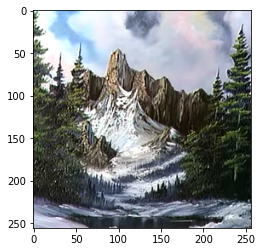

In [33]:
from google.colab import drive
drive.mount('/content/drive')

gan_config = GanConfig(learning_rate=3e-4,
                       gauss_factor=0.15,
                       kernel_size=3,
                       relu_alpha=0.1,
                       dropout_rate=0.7,
                       batch_norm_momentum=0.8,
                       latent_size=20,
                       style_size=100,
                       batch_size=8,
                       img_shape=(256,256,3),
                       preview_rows=3,
                       preview_cols=4,
                       data_path='/content/drive/MyDrive/Colab/BobRoss',
                       image_type=".png",
                       model_name='/GANVogh_bob_generator_model_')
 
gan_trainer = GanTrainer(gan_config)

In [34]:
#TRAINING
ERAS = 100
EPOCHS = 2500
BATCHES_PER_EPOCH = 10
PRINT_EVERY = 10

gan_trainer.train_n_eras(ERAS,EPOCHS,BATCHES_PER_EPOCH,PRINT_EVERY)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored